In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb 
from sklearn.cluster import KMeans, DBSCAN
import h3
from haversine import haversine, Unit
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder,StandardScaler,KBinsDiscretizer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,StratifiedKFold
import unittest
from sklearn.metrics import roc_curve, auc
import category_encoders as ce
import joblib


In [2]:
df = pd.read_csv('part1-dataset.csv')


In [3]:
df.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack
0,7/25/2022,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1
1,7/23/2022,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1
2,10/16/2022,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1
3,10/25/2022,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1
4,8/1/2022,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1


In [4]:
df.isna().sum()

created_date              0
deliverey_category_id     0
weekday                   0
first_created_at          0
time_bucket               0
total_distance           11
sum_product               0
source_latitude           0
source_longitude          0
destination_latitude      0
destination_longitude     0
final_customer_fare       0
final_biker_fare          0
first_customer_fare       0
hyper_ack                 0
dtype: int64

In [5]:
df[df['total_distance'].isna()]

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack
107,7/26/2022,0,2,2022-07-26 07:59:19+00:00,74,NaN,47,37.278187,60.617023,38.283955,61.620789,360000,180000,160000,0
1197,7/27/2022,0,3,2022-07-27 08:22:50+00:00,77,NaN,1,38.544949,46.067955,39.558018,47.066837,300000,270000,270000,0
2225,7/26/2022,0,2,2022-07-26 12:00:56+00:00,99,NaN,4,30.604658,53.503632,31.612669,54.488686,380000,190000,190000,0
2536,7/26/2022,0,2,2022-07-26 17:13:51+00:00,130,NaN,1,31.293264,58.036003,32.271000,59.036999,500000,300000,300000,0
2684,7/27/2022,0,3,2022-07-27 13:55:25+00:00,110,NaN,2,33.657097,52.666595,34.668800,53.669132,310000,170000,170000,0
2890,7/27/2022,0,3,2022-07-27 10:08:44+00:00,87,NaN,3,35.807655,49.499214,36.815987,50.489174,490000,250000,250000,0
2915,7/26/2022,0,2,2022-07-26 14:43:45+00:00,115,NaN,22,36.856873,51.979721,37.848442,53.006718,740000,350000,350000,0
2959,7/27/2022,0,3,2022-07-27 08:44:19+00:00,79,NaN,1,37.337059,60.534760,38.341328,61.527931,260000,170000,170000,0
2966,7/27/2022,0,3,2022-07-27 07:13:28+00:00,70,NaN,3,31.270609,57.997295,32.265574,59.004658,300000,240000,240000,0
6409,7/25/2022,4,1,2022-07-25 09:23:46+00:00,83,NaN,3,37.316563,60.522385,38.301601,61.536476,900000,480000,240000,1


In [6]:
df['distance'] = df[['destination_latitude','destination_longitude','source_latitude','source_longitude']].apply(lambda x:haversine((x[0],x[1]), (x[2],x[3]),unit='mi'),axis = 1 ) 

In [7]:
df.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,distance
0,7/25/2022,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1,89.886719
1,7/23/2022,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1,88.678364
2,10/16/2022,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1,89.552184
3,10/25/2022,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1,89.408283
4,8/1/2022,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1,87.901539


In [8]:
df.dropna(inplace=  True)

## Correlation and Colinearity analysis

In [9]:
df['first_created_at'] = pd.to_datetime(df['first_created_at'])
df['hour'] = df['first_created_at'].apply(lambda x: x.hour)

In [10]:
df.drop(columns = ['created_date','first_created_at'],inplace = True)

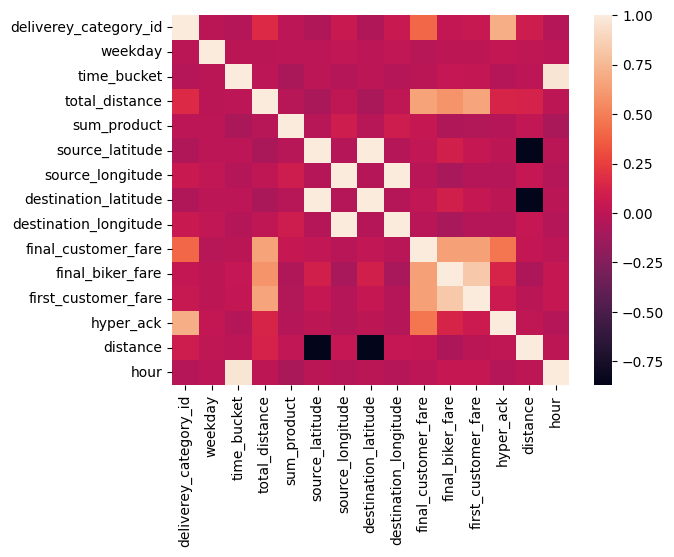

In [11]:
dataplot = sb.heatmap(df.corr()) 

In [12]:
df = df.drop(columns = ['final_biker_fare','first_customer_fare'])

In [13]:
df = df.drop(columns = ['hour'])

In [14]:
df['deliverey_category_id'].value_counts()

deliverey_category_id
0    7351
4    3743
1      13
Name: count, dtype: int64

In [15]:

contingency_table = pd.crosstab(df['deliverey_category_id'], df['hyper_ack'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:")
print(expected)



Chi-square Statistic: 5460.289717270709
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[3918.06248312 3432.93751688]
 [   6.92896372    6.07103628]
 [1995.00855316 1747.99144684]]


## Histograms

In [16]:

def histogram_plot(data,xlabel):
    mean_value = np.mean(data)
    median_value = np.median(data)

    plt.hist(data, bins=30, alpha=0.5, color='blue', edgecolor='black')

    # Plot mean
    plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    plt.text(mean_value, plt.ylim()[1]*0.95, 'Mean: {:.2f}'.format(mean_value), color = 'red')

    # Plot median
    plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2)
    plt.text(median_value, plt.ylim()[1]*0.90, 'Median: {:.2f}'.format(median_value), color = 'green')

    plt.title('Histogram with Mean and Median')
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')

    plt.show()

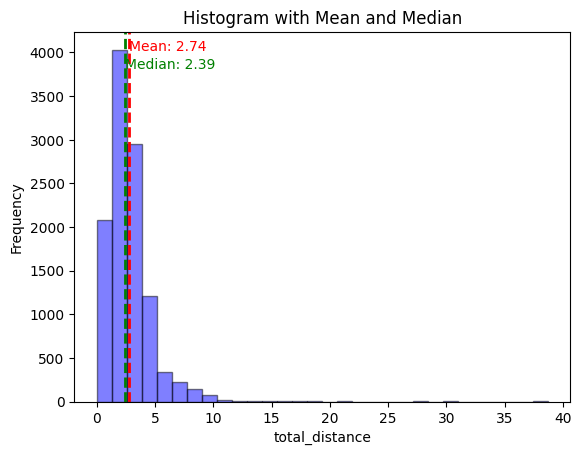

In [17]:
histogram_plot(df['total_distance'],xlabel='total_distance')

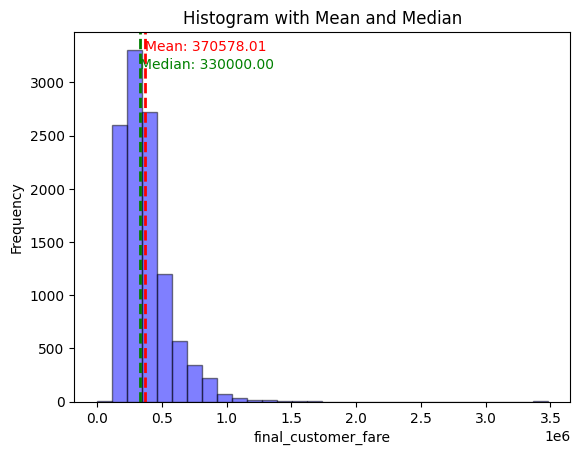

In [18]:
histogram_plot(df['final_customer_fare'],xlabel='final_customer_fare')

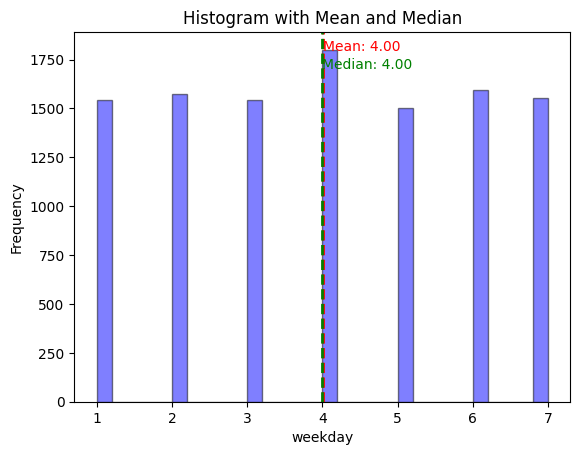

In [19]:
histogram_plot(df['weekday'],xlabel='weekday')

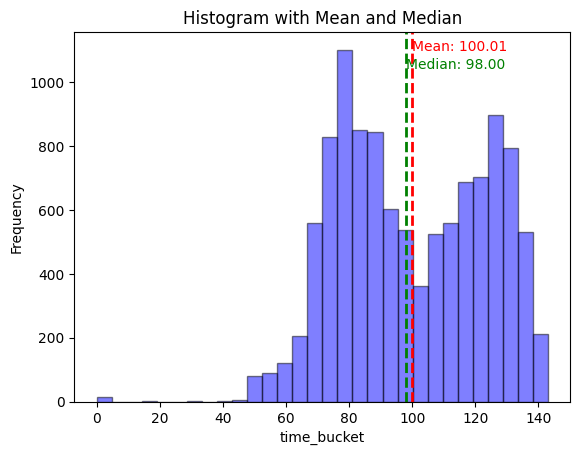

In [20]:
histogram_plot(df['time_bucket'],xlabel='time_bucket')

In [21]:
#df = df.loc[df['time_bucket']>=50]
#df.loc[(df['time_bucket']>=50) & (df['time_bucket']<=100)  ,'time_bucket']=0
#df.loc[(df['time_bucket']>100) ,'time_bucket' ]=1

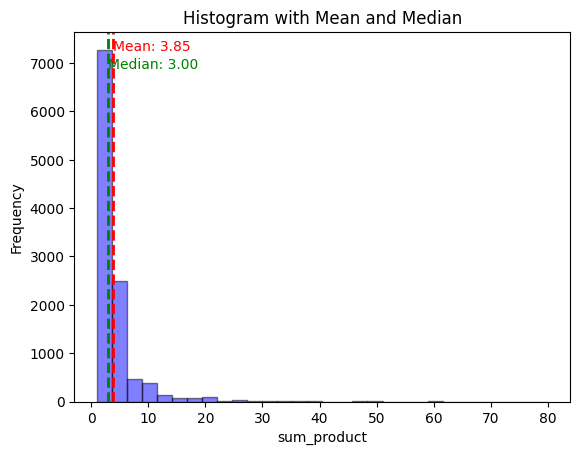

In [22]:
histogram_plot(df['sum_product'],xlabel='sum_product')

In [23]:
#df.loc[df['sum_product']<= 10,'sum_product'] = 0
#df.loc[df['sum_product']> 10,'sum_product'] = 1

## Outlier Removal

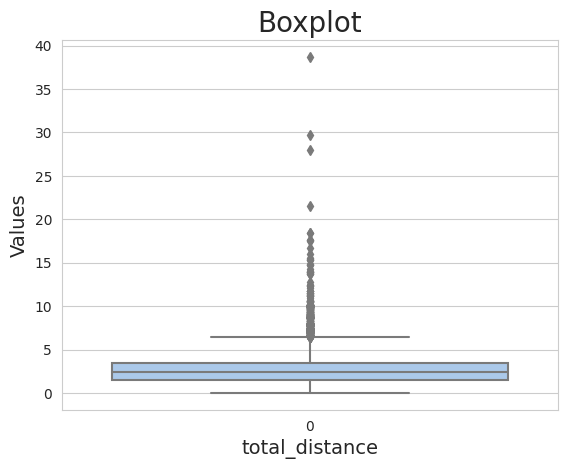

In [24]:

sb.set_style("whitegrid")


sb.boxplot(data=df['total_distance'], palette="pastel")

plt.title('Boxplot', fontsize=20)
plt.xlabel('total_distance', fontsize=14)
plt.ylabel('Values', fontsize=14)

plt.show()

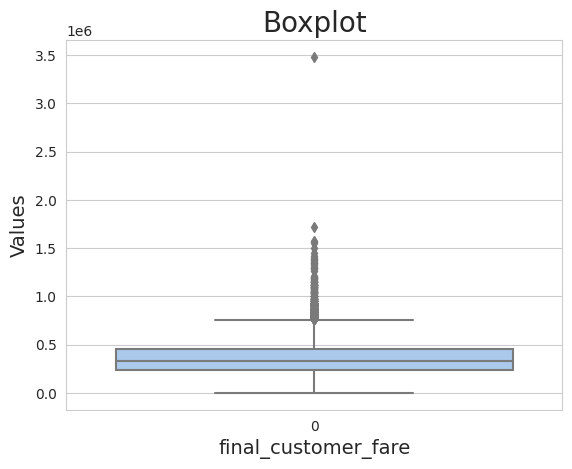

In [25]:

sb.set_style("whitegrid")


sb.boxplot(data=df['final_customer_fare'], palette="pastel")

plt.title('Boxplot', fontsize=20)
plt.xlabel('final_customer_fare', fontsize=14)
plt.ylabel('Values', fontsize=14)

plt.show()

In [26]:
df.shape

(11107, 12)

In [27]:
def outlier_removal(data,column,upper,lower):
        Q1 = data[column].quantile(lower)
        Q3 = data[column].quantile(upper)
        
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = (data[column] > lower_bound) & (data[column] < upper_bound)
        return data[mask].reset_index().drop(columns = 'index')

In [28]:
df = outlier_removal(df,column='total_distance',upper = .75,lower=.25 )

In [29]:
df = outlier_removal(df,column='final_customer_fare',upper = .75,lower=.25 )

## Clustering the Geolocations

### Segement based on Hexagons

In [30]:

resolution = 12
df['source_hexagonID'] = df.loc[:,['source_latitude','source_longitude']].apply(lambda x: h3.geo_to_h3(x[0], x[1], resolution),axis = 1)
df['destination_hexagonID'] = df.loc[:,['destination_latitude','destination_longitude']].apply(lambda x: h3.geo_to_h3(x[0], x[1], resolution),axis = 1)

le = LabelEncoder()
le = LabelEncoder()
le.fit(df['source_hexagonID'].tolist()+df['destination_hexagonID'].tolist() )
df['source_hexagonID'] = le.transform(df[ 'source_hexagonID'])
df['destination_hexagonID'] = le.transform(df[ 'destination_hexagonID'])


### Clustering with SBScan and Kmeans

In [31]:
def clustering(Method,data):
    if Method == 'DBSCAN':
        return DBSCAN(eps=.01,min_samples=20).fit(data)
    if Method == 'KMeans':
        kmeans = KMeans(n_clusters=20, random_state=0, n_init="auto").fit(data)
        data['source_labels'] = kmeans.predict(data)
        counter = -1
        for label in np.unique( kmeans.labels_):
            data.loc[data['source_labels']==label, ['centroid_lat','centroid_lng']] = kmeans.cluster_centers_[label]
        return data[['centroid_lat','centroid_lng']]

In [32]:
df['source_labels']  = clustering(Method='DBSCAN',data=df.loc[:,['source_latitude','source_longitude']]).labels_
df['destination_labels']  = clustering(Method='DBSCAN',data=df.loc[:,['destination_latitude','destination_longitude']]).labels_
df[['source_lat','source_lng']]  = clustering(Method='KMeans',data=df.loc[:,['source_latitude','source_longitude']])
df[['destination_lat','destination_lng']]  = clustering(Method='KMeans',data=df.loc[:,['destination_latitude','destination_longitude']])


In [33]:
df = df[df['deliverey_category_id']!=1]
df.loc[df['deliverey_category_id']==4,'deliverey_category_id'] =1

In [34]:
df.head()

,deliverey_category_id,weekday,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,hyper_ack,distance,source_hexagonID,destination_hexagonID,source_labels,destination_labels,source_lat,source_lng,destination_lat,destination_lng
0,0,1,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,1,89.886719,11877,12445,0,0,30.645346,53.493766,31.645970,54.493129
1,0,6,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,1,88.678364,37,2023,14,-1,37.317682,60.544638,38.317999,61.544686
2,0,7,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,1,89.552184,9619,7963,1,1,33.661439,52.676355,34.661479,53.675813
3,0,1,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,1,87.901539,7027,5190,2,2,36.817711,51.971589,37.817411,52.970859
4,0,2,101,2.3040,3,31.273190,58.074833,32.285353,59.085854,270000,1,91.743078,11265,13895,-1,-1,31.287987,58.043913,32.286453,59.043866


## Scatter plot of sum product vs total distance

/tmp/ipykernel_230841/276765970.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  scatter = sb.scatterplot(data=df, x="total_distance", y="sum_product", palette="deep", s=100)


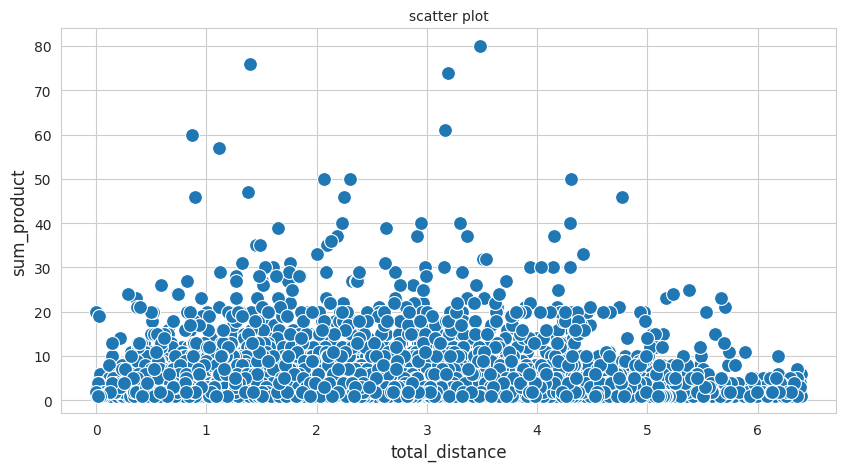

In [35]:
sb.set_style("whitegrid")

plt.figure(figsize=(10, 5))
scatter = sb.scatterplot(data=df, x="total_distance", y="sum_product", palette="deep", s=100)

scatter.set_title('scatter plot', fontsize=10)
scatter.set_xlabel('total_distance', fontsize=12)
scatter.set_ylabel('sum_product', fontsize=12)


plt.show()

## Checking the PCA Impact

<BarContainer object of 7 artists>

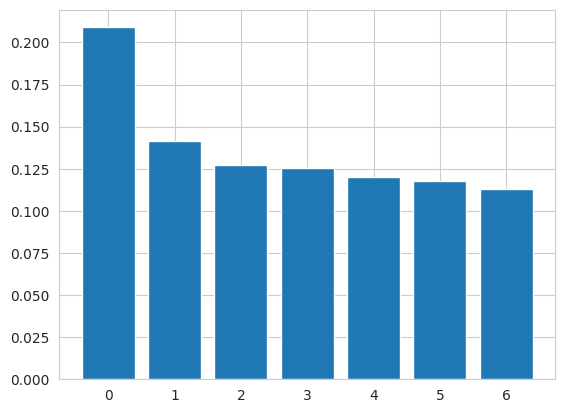

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7, svd_solver='arpack')
sc = StandardScaler()
dd = sc.fit_transform(df[['deliverey_category_id','weekday','time_bucket','total_distance','sum_product','final_customer_fare',
       'destination_lat', 'destination_lng']])
pca.fit(dd)
plt.bar(range(0,len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)

## Model Development and Training

In [38]:
class DataPreprocessor(unittest.TestCase):
    def __init__(self, data):
        self.data = data
        self.X = None
        self.y = None
        self.assertAlmostEqual(sum(self.data.isna().sum()), 0, places=5,
                                       msg=f"There are some missing values in data that you did not handled")
    def preprocessing(self, **kwargs):
        self.X = self.data.drop(columns='hyper_ack')
        self.y = self.data['hyper_ack']
        
        if kwargs.get('encoder'):
            encoder = ce.BinaryEncoder(cols=kwargs.get('features_to_encode', []))
            self.X = encoder.fit_transform(self.X)

        if kwargs.get('normalization'):
            sc = StandardScaler()
            features_to_normalize = kwargs.get('features_to_normalize', [])
            self.X[features_to_normalize] = sc.fit_transform(self.X[features_to_normalize])
            
            for column in features_to_normalize:
                self.assertAlmostEqual(self.X[column].mean(), 0, places=5,
                                       msg=f"The mean of column {column} after normalization is not approximately zero.")
                self.assertAlmostEqual(round(self.X[column].var()), 1, places=5,
                                       msg=f"The variance of column {column} after normalization is not approximately one.")

        if kwargs.get('oversampling'):
            smote = SMOTE(sampling_strategy='minority', k_neighbors=5)
            self.X, self.y = smote.fit_resample(self.X, self.y)
            
        if kwargs.get('bucketize'):
            features_to_discretize = kwargs.get('features_to_discretize', [])
            discretizer = KBinsDiscretizer(n_bins=15, encode='ordinal', strategy='kmeans')
            discretized_features = discretizer.fit_transform(self.X[features_to_discretize])
            df_discretized = pd.DataFrame(discretized_features, columns=[feature+'_bins' for feature in features_to_discretize])
            self.X = self.X.join(df_discretized).drop(columns=features_to_discretize)
            
 

In [129]:

class ModelTrainer():
    def __init__(self, data_preprocessor):
        self.X = data_preprocessor.X
        self.y = data_preprocessor.y
        self.models = {
            "XGboost": xgb.XGBClassifier(
                            max_depth=10,            
                            learning_rate=0.01,  
                            subsample=.5,
                            n_estimators=20,       
                            objective='binary:logistic', 
                            booster='gbtree',      
                            gamma=.5,               
                            reg_alpha=0,            
                            reg_lambda=1,           
                            random_state=42         
                        ),
            "SVM": SVC(kernel='rbf', probability=True, C= 1.5, gamma ='scale'),
            "LogisticRegression": LogisticRegression(max_iter=200,penalty='l2', solver='liblinear')
        }
        self.model_scores = {}
        self.best_model_name = None
           
    

    def model_fit(self, n_splits=5):
        
        kf = StratifiedKFold(n_splits=n_splits)

        for name, model in self.models.items():
            scores = cross_val_score(model, self.X, self.y, cv=kf,scoring='f1')
            self.model_scores[name] = {'mean': scores.mean(), 'std': scores.std()}
            #print(f"{name}: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")
            print(f"{name}: {scores} ,Mean: {scores.mean():.2f} (+/- {scores.std() * 2:.2f}) ")
    def select_best_model(self):
        best_score = -1
        for model_name, metrics in self.model_scores.items():
            if metrics['mean'] > best_score:
                best_score = metrics['mean']
                self.best_model_name = model_name

        print(f"Best Model: {self.best_model_name} with score: {best_score}")

    def best_model_metrics(self):
        
        if not self.best_model_name:
            print("Please run select_best_model() to determine the best model first.")
            return
        
        
        best_model = self.models[self.best_model_name]
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2)

        best_model.fit(X_train, y_train)
        print(classification_report(y_test,best_model.predict(X_test)))
        if self.best_model_name== "XGboost":
            best_model.save_model('best_model.json')
            xgb.plot_importance(best_model)
            plt.show()
            
            explainer = shap.Explainer(best_model)
            shap_values = explainer(X_train)
            shap.summary_plot(shap_values, X_train)
        else:
            joblib.dump(best_model, 'best_model.joblib')
            fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
            roc_auc = auc(fpr, tpr)

            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

    

            
        
        return best_model

In [130]:
df.columns

Index(['deliverey_category_id', 'weekday', 'time_bucket', 'total_distance',
       'sum_product', 'source_latitude', 'source_longitude',
       'destination_latitude', 'destination_longitude', 'final_customer_fare',
       'hyper_ack', 'distance', 'source_hexagonID', 'destination_hexagonID',
       'source_labels', 'destination_labels', 'source_lat', 'source_lng',
       'destination_lat', 'destination_lng'],
      dtype='object')

/home/raziyeh/.local/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:239: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


XGboost: [0.93708755 0.97654584 0.98305085 0.95314479 0.78097983] ,Mean: 0.93 (+/- 0.15) 
SVM: [0.94818182 0.92994199 0.97962722 0.96849374 0.92961487] ,Mean: 0.95 (+/- 0.04) 
LogisticRegression: [0.9300828  0.95238095 0.97457992 0.98512686 0.86889251] ,Mean: 0.94 (+/- 0.08) 
Best Model: SVM with score: 0.9511719291220352
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1144
           1       0.99      0.95      0.97      1152

    accuracy                           0.97      2296
   macro avg       0.97      0.97      0.97      2296
weighted avg       0.97      0.97      0.97      2296



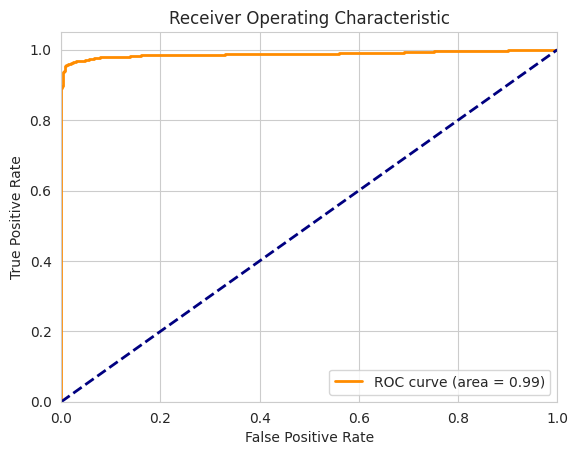

SVC(C=1.5, probability=True)

In [131]:
features = ['deliverey_category_id','weekday','time_bucket','total_distance','sum_product','final_customer_fare',
        'destination_hexagonID','source_hexagonID','hyper_ack']
features_to_normalize=['time_bucket','total_distance','sum_product','final_customer_fare']
features_to_encode = ['weekday','source_hexagonID', 'destination_hexagonID']
features_to_discretize = ['final_customer_fare','total_distance','sum_product']

data_preprocessor = DataPreprocessor(df[features])

data_preprocessor.preprocessing(features_to_normalize=features_to_normalize,features_to_encode=features_to_encode,
                            features_to_discretize=features_to_discretize,
                            bucketize= True,encoder = True, oversampling = True, normalization = True)


model_trainer = ModelTrainer(data_preprocessor)

model_trainer.model_fit(n_splits=5)
model_trainer.select_best_model()
model_trainer.best_model_metrics()